In [1]:
import os

import numpy as np
import pandas as pd

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation



import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_color_codes("colorblind")
sns.set_style("whitegrid")
sns.set_context("notebook")



In [2]:
#cwd=os.getcwd()
#cwd
#os.listdir('.')

# Data

Data is importedand cleaned

In [3]:
file='forecasting_take_home_data.xlsx'
raw_data=pd.read_excel(file,skiprows=11)
data=raw_data.rename(columns={raw_data.columns[0]:'Date', raw_data.columns[1]:'Price' })
data.Date = pd.to_datetime(data.Date)
data['Year'] = pd.DatetimeIndex(data['Date']).year
data['Month'] = pd.DatetimeIndex(data['Date']).month
data.head()

,Date,Price,Year,Month
0,1992-01-01,1.022,1992,1
1,1992-02-01,1.006,1992,2
2,1992-03-01,1.013,1992,3
3,1992-04-01,1.052,1992,4
4,1992-05-01,1.107,1992,5


# Functions

In [4]:
def plot_data(df, column, title, x="Date",kind="line"):
    """ 2D Graph 2 variables, x and kind are are optional, and kind ={'linear', 'scatter'}"""
    g=sns.relplot(x=x,
                y=column, 
                data=df,
                kind=kind)
    plt.title(title, y=1.05)
    #plt.grid(False)
    plt.show()

In [5]:
def plot_data_3var(df, column, title, x="Date",z='Month',kind="line"):
        """ 2D Graph 3 variables, x and kind are are optional, and kind ={'linear', 'scatter'}"""
        g=sns.relplot(x=x,
                     y=column, 
                     data=df,
                     hue=z,
                     kind=kind)
        plt.xlabel(x)
        plt.ylabel(column)
        plt.title(title+"  / " + z+"ly" , y=1.05)
        plt.show()

### fbProphet

In [6]:
def plot_train_test(train, test,kind='scatter'):
    """Plots test and training sets"""
    A=test.rename(columns={'y': 'TESTING SET'})
    B=train.rename(columns={'y': 'TRAINING SET'})
    C=pd.concat([B,A])
    ax = plt.gca()
    C.plot(kind= kind,x='ds',y='TESTING SET',color='red',ax=ax)
    C.plot(kind= kind,x='ds',y='TRAINING SET', color='black', ax=ax)
    plt.show()



In [7]:
# Plot the forecast
def plot_forecast(model,test_fcst):
    """Plots forecast larger"""
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(8)
    fig = model.plot(test_fcst,ax=ax)
    plt.show()

In [8]:
def plot_comparisson(model,test,test_fcst):
    """comparisson test and forcast"""
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    ax.scatter(test.ds, test.y, color='r')
    fig = model.plot(test_fcst, ax=ax)
    plt.show()

In [9]:
# Plot the components of the model
def plot_component_fcst(model, test_fcst):
    plt.rcParams.update({'figure.figsize':(6,5), 'figure.dpi':80})
    fig = model.plot_components(test_fcst)
    plt.show()

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def errors(test,test_fcst):
    """Dict of errors"""
    error={}

    y_true=test['y']
    y_pred=test_fcst['yhat']
    error["MSE"]=mean_squared_error(y_true,y_pred)
    error["MAE"]=mean_absolute_error(y_true,y_pred)
    error["MAPE"]=mean_absolute_percentage_error(y_true,y_pred)
    return error

In [11]:
def correct_pred(test,test_fcst):
    result = pd.merge(test, test_fcst[["ds",'yhat_lower','yhat_upper']], on="ds")
    result.loc[(result['yhat_lower'] <=result['y']) & (result['yhat_upper'] >= result['y']), 'res']=1
    result.fillna(0)
    pts=int(result["res"].sum())
    perc=round(pts/len(test),4)
    return [pts, perc]

## EDA

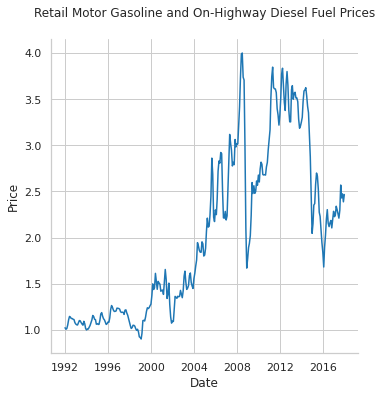

In [12]:
plot_data(data,"Price",'Retail Motor Gasoline and On-Highway Diesel Fuel Prices')

Droped: 
        
        Sep 97-Feb 99
        
        May-Dec 2001
        
        Jun 08-Dec08
        
        May14-Feb 15
       

Unanticipated changes: 
        
        Jul 08-Dec 08-Jun 09
        
        April 10-May 11
        
        May 14-Feb 15-Jun 15-Feb 16 -May 2016

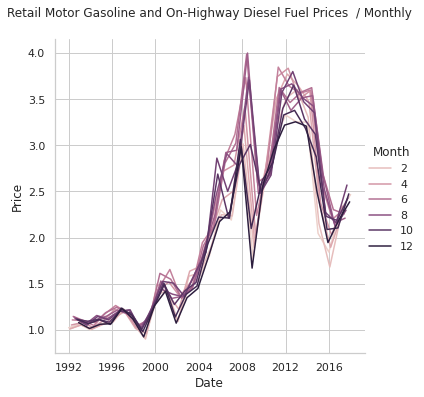

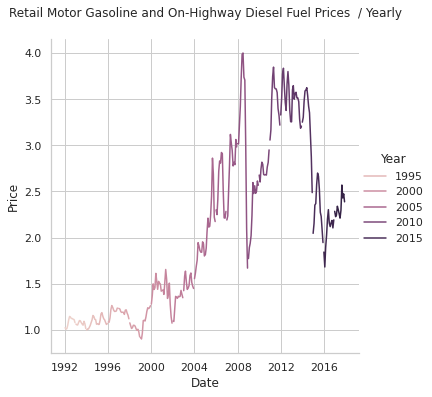

In [13]:
plot_data_3var(data,"Price",'Retail Motor Gasoline and On-Highway Diesel Fuel Prices',z="Month")
plot_data_3var(data,"Price",'Retail Motor Gasoline and On-Highway Diesel Fuel Prices',z="Year")


The season(period) amplitud seems to growing as time passes. It might be suggesting  a multiplicative seasonal series

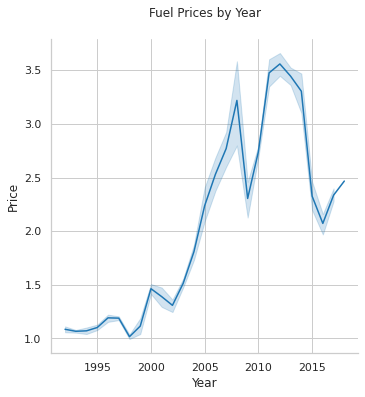

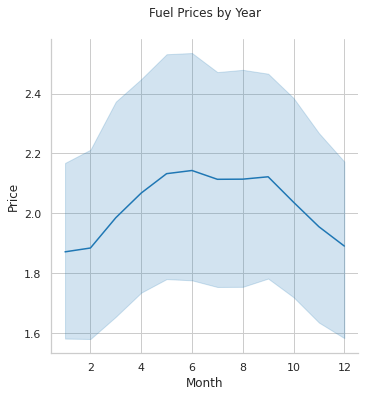

In [14]:
plot_data(data,"Price",'Fuel Prices by Year',"Year")
plot_data(data,"Price",'Fuel Prices by Year',"Month")

Yearly-Month "Regression" confirms abrupt change on Jun 08- Jun 09 and May 14-Feb 16.


Month-Year "Regression" shows April-September price reach high, and Oct-April price reaches min. Period- 1 year



# Prophet

Formating data for fbprophet

In [15]:
df = data[["Date","Price"]].copy()
df.columns = ["ds","y"]
df.head(3)

,ds,y
0,1992-01-01,1.022
1,1992-02-01,1.006
2,1992-03-01,1.013


Splitting data: Train and Test set. n is the number of forecasted periods

In [16]:
Lenght=len(data)
n=14 #18 #20 #round(Lenght * .1)
Part= Lenght - n

In [17]:
split_date = df.ds.iloc[Part]
train = df.loc[df.ds <= split_date].copy()
test = df.loc[df.ds > split_date].copy()

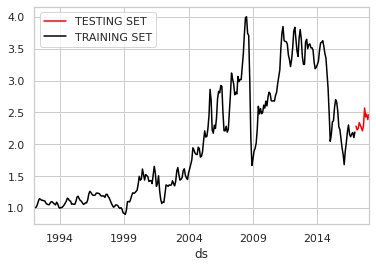

In [18]:
plot_train_test(train,test,"line")

### Basic Model

In [19]:
model_Basic = Prophet(weekly_seasonality=False, 
                daily_seasonality=False)
model_Basic.fit(train)
future = model_Basic.make_future_dataframe(periods=n, freq="MS")

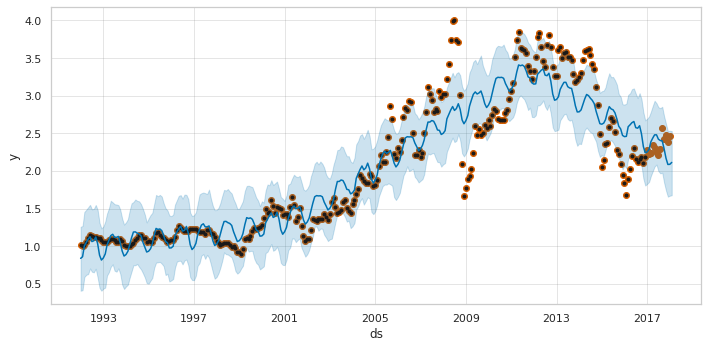

In [20]:
future_fcst =model_Basic.predict(future)
train_fcst = model_Basic.predict(train)
test_fcst = model_Basic.predict(test)
plot_comparisson( model_Basic,df,future_fcst)

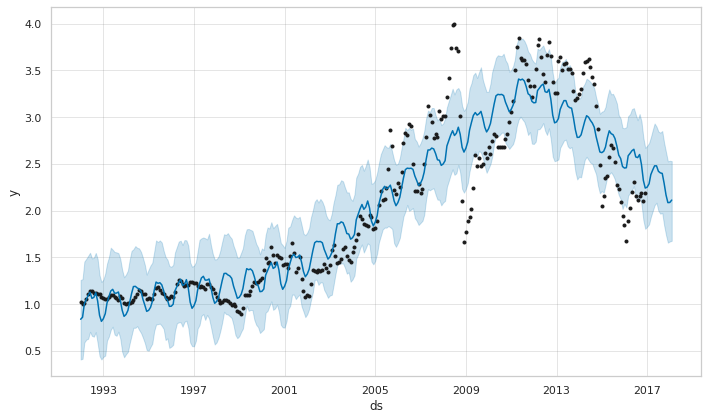

In [21]:
fig = model_Basic.plot(future_fcst)

In [22]:
TestErrors={}
TrainErrors={}
Correct={}
CorrectPerc={}

TestErrors["Basic"]=errors(test,test_fcst)
TrainErrors["Basic"]=errors(train,train_fcst)
Correct["Basic"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["Basic"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

### Additive Changing trend

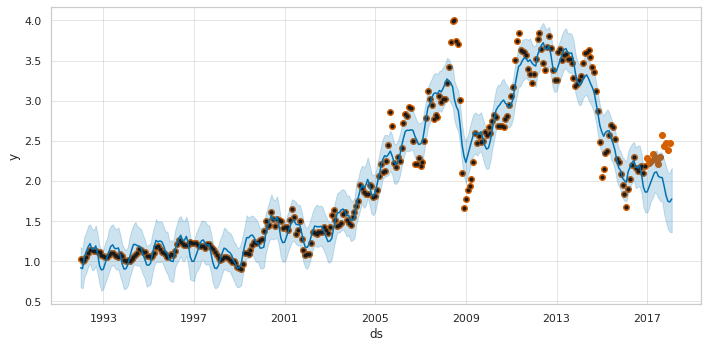

In [23]:
model_ACT = Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
               changepoint_prior_scale=1,
                changepoint_range=.95)
model_ACT.fit(train)

future_fcst =model_ACT.predict(future)
train_fcst =model_ACT.predict(train)
test_fcst = model_ACT.predict(test)
plot_comparisson(model_ACT,df,future_fcst)

In [24]:
TestErrors["ACT"]=errors(test,test_fcst)
TrainErrors["ACT"]=errors(train,train_fcst)
Correct["ACT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["ACT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

### Multiplicative Changing trend

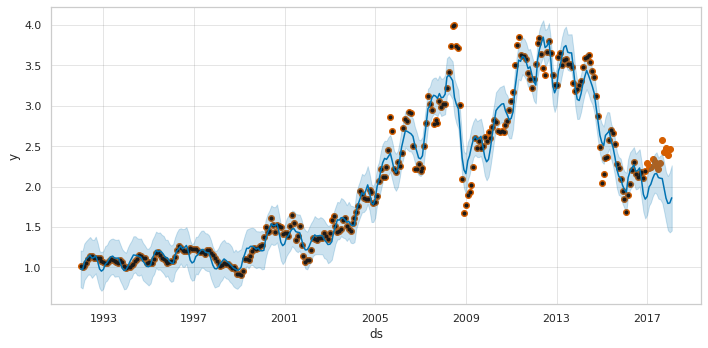

In [25]:
model_MCT= Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
               changepoint_prior_scale=1,
               seasonality_mode='multiplicative',
                changepoint_range=.95 )
model_MCT.fit(train)

future_fcst =model_MCT.predict(future)
train_fcst =model_MCT.predict(train)
test_fcst = model_MCT.predict(test)
plot_comparisson(model_MCT,df,future_fcst)

In [26]:
TestErrors["MCT"]=errors(test,test_fcst)
TrainErrors["MCT"]=errors(train,train_fcst)
Correct["MCT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["MCT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

### Holidays

Consider US Holidays and Recessions

Within the data, Wikipedia (https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States) shows 2 recession: Early 2000's (March - November 2001) and Great Recession (Dec 2007-June 2009). This last one captures the largest fuel price drop.   


In [27]:
recession=future.copy()

In [28]:
# Mar 2001-Nov 2001
recession.loc[(recession['ds'] >= '2001-03-01') & (recession['ds'] <= '2001-11-01'), 'holiday'] = "Early 2000's Recession"
# Dec 2007-June 2009
recession.loc[(recession['ds'] >= '2007-12-01') & (recession['ds'] <= '2009-06-01'), 'holiday'] =  "Great Recession"
recession.dropna(axis=0,inplace=True)

In [29]:
recession=recession.dropna(axis=0)
recession["lower_window"]=0
recession['upper_window']=1

In [30]:
holidays=recession.copy()

#### Recession ACT

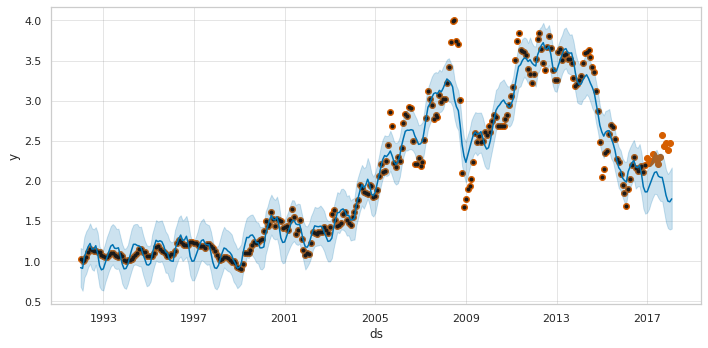

In [31]:
model_RACT= Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
               changepoint_prior_scale=1,
                    changepoint_range=.95 )
model_RACT.fit(train)

future_fcst =model_RACT.predict(future)
train_fcst =model_RACT.predict(train)
test_fcst = model_RACT.predict(test)
plot_comparisson(model_RACT,df,future_fcst)


In [32]:
TestErrors["RACT"]=errors(test,test_fcst)
TrainErrors["RACT"]=errors(train,train_fcst)
Correct["RACT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["RACT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

#### Recession MCT

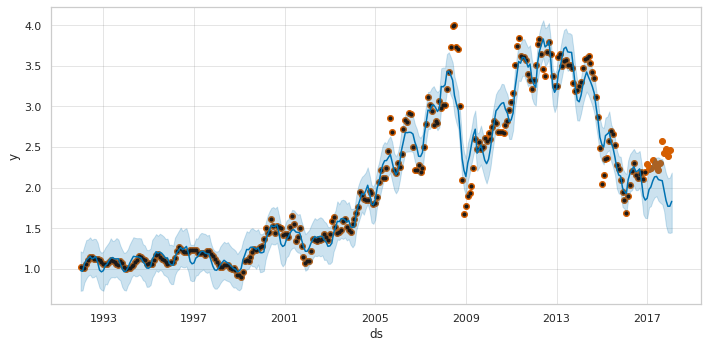

In [33]:
model_RMCT= Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
                changepoint_prior_scale=1,
                seasonality_mode='multiplicative',
                changepoint_range=.95,
                holidays=holidays)
model_RMCT.fit(train)

future_fcst =model_RMCT.predict(future)
train_fcst =model_RMCT.predict(train)
test_fcst = model_RMCT.predict(test)

plot_comparisson(model_RMCT,df,future_fcst)

In [34]:
Correct["OHRMCT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])

In [35]:
TestErrors["RMCT"]=errors(test,test_fcst)
TrainErrors["RMCT"]=errors(train,train_fcst)
Correct["RMCT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["RMCT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

In [36]:
model_RMCT.train_holiday_names

0    Early 2000's Recession
1           Great Recession
dtype: object

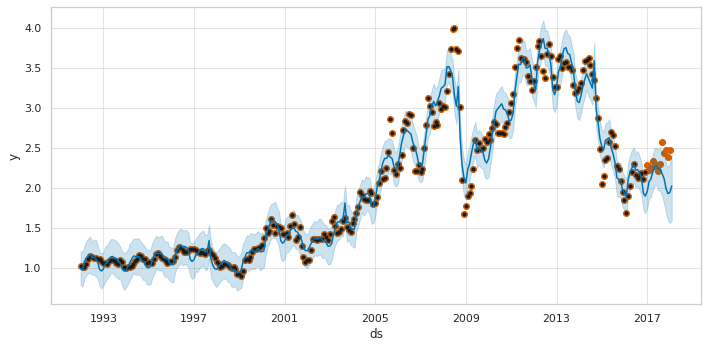

In [37]:
model_HRMCT= Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
                changepoint_prior_scale=1,
                seasonality_mode='multiplicative',
                changepoint_range=.95,
                holidays=holidays)
model_HRMCT.add_country_holidays(country_name='US')
model_HRMCT.fit(train)

future_fcst =model_HRMCT.predict(future)
train_fcst =model_HRMCT.predict(train)
test_fcst = model_HRMCT.predict(test)

plot_comparisson(model_HRMCT,df,future_fcst)


In [38]:
TestErrors["HRMCT"]=errors(test,test_fcst)
TrainErrors["HRMCT"]=errors(train,train_fcst)
Correct["HRMCT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["HRMCT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

In [39]:
model_HRMCT.train_holiday_names

0          Early 2000's Recession
1                 Great Recession
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7     Independence Day (Observed)
8                       Labor Day
9                    Columbus Day
10                   Veterans Day
11                   Thanksgiving
12                  Christmas Day
13      New Year's Day (Observed)
14       Christmas Day (Observed)
15        Veterans Day (Observed)
dtype: object

### Holidays and Outlier

In [40]:
df0=df.copy()

In [41]:
df0.loc[(df0['ds'] > '2015-11-01') & (df['ds'] < '2016-04-01'), 'y'] = None

In [42]:

train0 = df0.loc[df0.ds <= split_date].copy()
test0 = df0.loc[df0.ds > split_date].copy()

In [43]:
holidays=recession.copy()

In [44]:
model_OHRMCT= Prophet(weekly_seasonality=False, 
                daily_seasonality=False,
                changepoint_prior_scale=1,
                seasonality_mode='multiplicative',
                changepoint_range=.95,
                holidays=holidays)
model_OHRMCT.add_country_holidays(country_name='US')
model_OHRMCT.fit(df0)


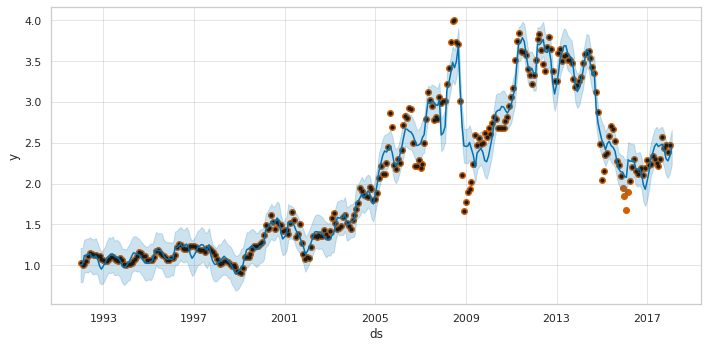

In [45]:
future_fcst =model_OHRMCT.predict(future)
train_fcst =model_OHRMCT.predict(train)
test_fcst = model_OHRMCT.predict(test)
plot_comparisson(model_OHRMCT,df,future_fcst)

In [46]:
TestErrors["OHRMCT"]=errors(test,test_fcst)
TrainErrors["OHRMCT"]=errors(train,train_fcst)
Correct["OHRMCT"]=(correct_pred(train,train_fcst)[0],correct_pred(test,test_fcst)[0])
CorrectPerc["OHRMCT"]=(correct_pred(train,train_fcst)[1],correct_pred(test,test_fcst)[1])

# Summary

In [47]:
# Erros on Test Set
TEST=pd.DataFrame(TestErrors).T
TEST.head()

,MSE,MAE,MAPE
Basic,0.042103,0.180360,7.618794
ACT,0.188840,0.389232,16.329245
MCT,0.154924,0.341337,14.282833
RACT,0.188840,0.389232,16.329245
RMCT,0.167753,0.359508,15.058902


In [48]:
# Erros on Train Set
TRAIN=pd.DataFrame(TrainErrors).T

In [49]:
TRAIN.head()

,MSE,MAE,MAPE
Basic,0.113457,0.255518,12.473362
ACT,0.038357,0.138512,7.076435
MCT,0.031699,0.123100,5.944477
RACT,0.038357,0.138512,7.076435
RMCT,0.032236,0.125771,6.060988


In [50]:
# Number of points within the uncertainty interval
Correctness=pd.DataFrame(Correct,index = ['Train','Test']).T
Correctness

,Train,Test
Basic,239,13
ACT,254,4
MCT,255,6
RACT,255,4
OHRMCT,252,10
RMCT,254,4
HRMCT,246,8


In [51]:
#Percentage of points within the uncertainty interval
PerCorrectness=pd.DataFrame(CorrectPerc,index = ['Train','Test']).T
PerCorrectness

,Train,Test
Basic,0.7967,1.0000
ACT,0.8467,0.3077
MCT,0.8500,0.4615
RACT,0.8500,0.3077
RMCT,0.8467,0.3077
HRMCT,0.8200,0.6154
OHRMCT,0.8400,0.7692


# ``Best'' Model 

In [52]:
print("Based on MAE, the best performing model for the training data is ", TRAIN[["MAE"]].idxmin()[0],"\n and for the testing data is ", TRAIN[["MAE"]].idxmin()[0])

Based on MAE, the best performing model for the training data is  OHRMCT 
 and for the testing data is  OHRMCT


In [53]:
print("Based on MSE, the best performing model for the training data is ", TRAIN[["MSE"]].idxmin()[0],"\n and for the testing data is ", TRAIN[["MSE"]].idxmin()[0])

Based on MSE, the best performing model for the training data is  OHRMCT 
 and for the testing data is  OHRMCT


In [54]:
m=TRAIN[["MAE"]].idxmin()[0]

Errors on Training:

In [55]:
for key in TrainErrors[m]:
    print(key , " = ",  round(TrainErrors[m][key],4) )

MSE  =  0.0277
MAE  =  0.1116
MAPE  =  5.5022


In [56]:
for key in TestErrors[m]:
    print(key , " = ",  round(TestErrors[m][key],4) )

MSE  =  0.0237
MAE  =  0.1334
MAPE  =  5.7469


In [57]:
print("Number of training values within the uncertainty interval:" ,Correct[m][0],"out of",Part,
      "\n Number of testing values within the uncertainty interval:" ,Correct["HRMCT"][1],"out of",n)

Number of training values within the uncertainty interval: 252 out of 299 
 Number of testing values within the uncertainty interval: 8 out of 14


In [58]:
print("Percentage training values within the uncertainty interval:" ,CorrectPerc[m][0],"out of",Part,
      "\n Percentage testing values within the uncertainty interval:" ,CorrectPerc[m][1],"out of",n)

Percentage training values within the uncertainty interval: 0.84 out of 299 
 Percentage testing values within the uncertainty interval: 0.7692 out of 14


## Crossvalidation

It keeps showing error and warning messages, I could not figure out how to fix it.

In [59]:
#df_cv = cross_validation(model_HRMCT, initial='370 days', period='12 M', horizon = '36 M')

## Randomness of the series

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [61]:

data_series=data.set_index("Date")
# Compute and print ADF p-value
result = adfuller(data_series["Price"])
print("The p-value for the ADF test is ", result[1])
# p-value >.05, we cannot reject the hypothesis that the series is a random walk

The p-value for the ADF test is  0.5648602941341625


In [62]:
def plot_series_acf_pacf(df,col,title):
    plt.rcParams.update({'figure.figsize':(17,6), 'figure.dpi':120})
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
    ax1.plot(df[col]); 
    ax1.set_title(title)
    plot_acf(df[col], ax=ax2)
    plot_pacf(df[col], lags= 20, alpha=0.05, ax=ax3)
    plt.show()

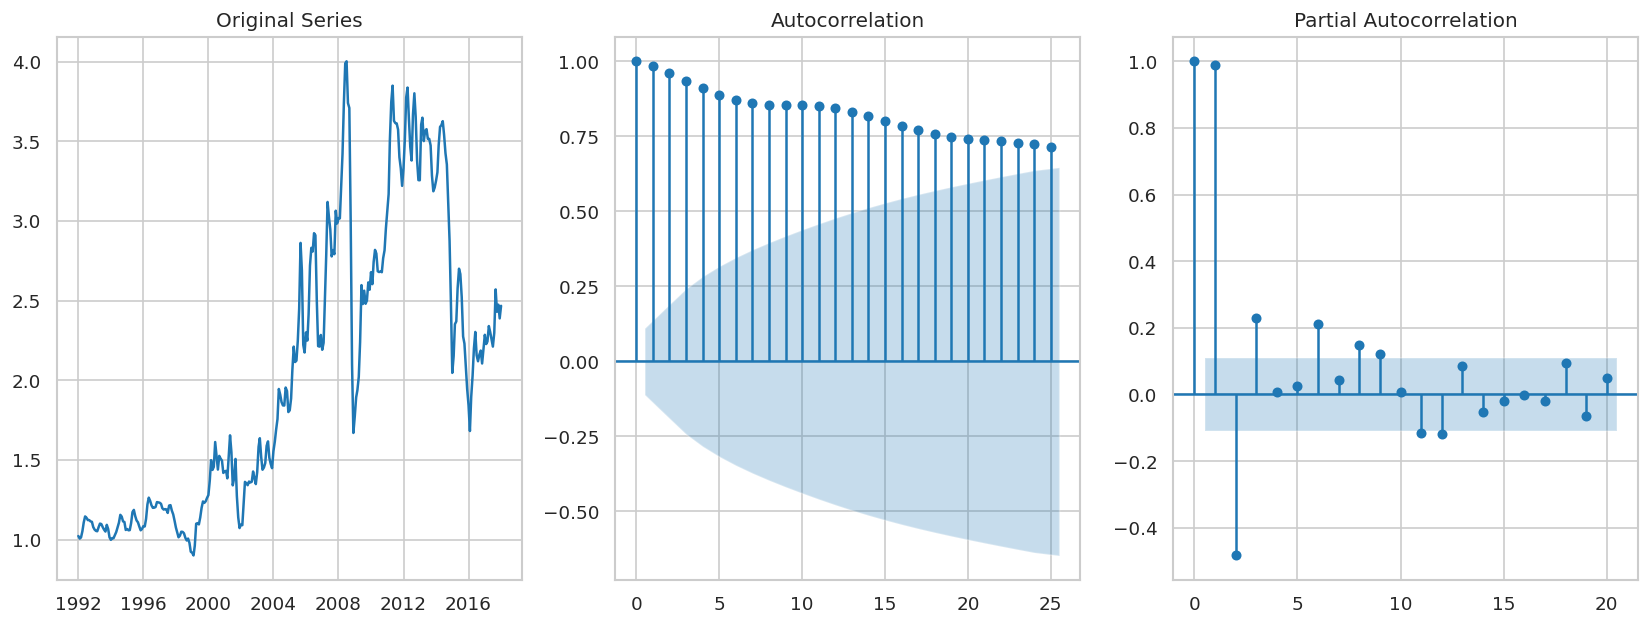

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


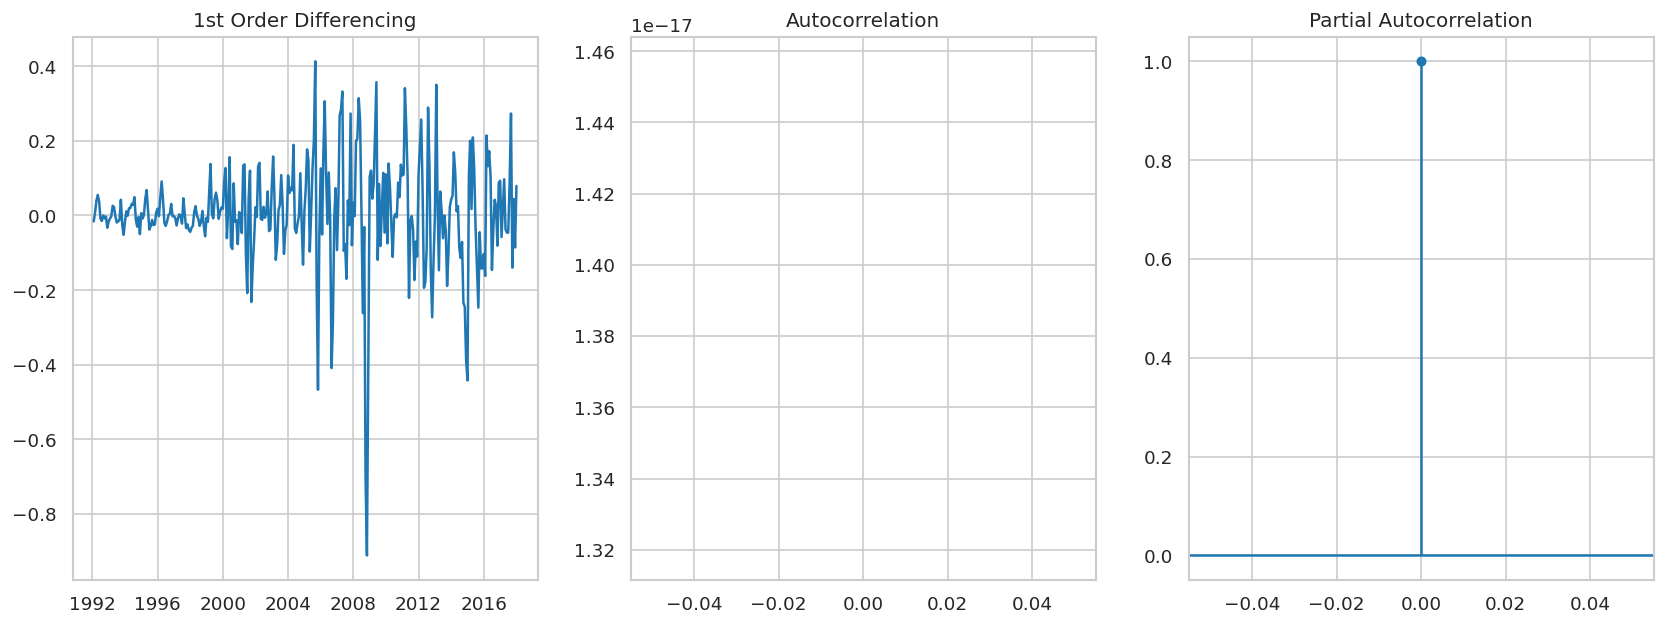

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


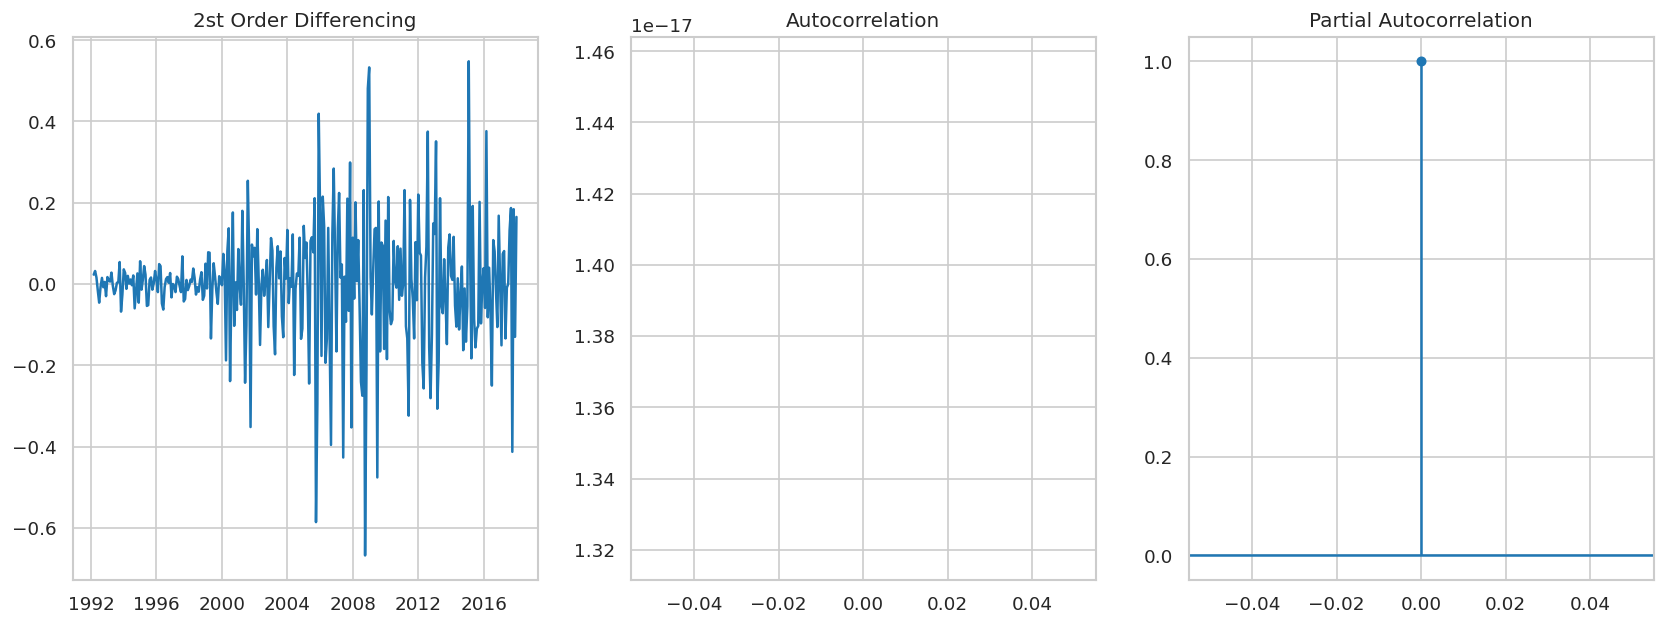

In [63]:
data_series["firstOrder"]=data_series.Price.diff()
data_series["secondOrder"]=data_series.firstOrder.diff()
plot_series_acf_pacf(data_series, "Price", title='Original Series')
plot_series_acf_pacf(data_series, "firstOrder", title='1st Order Differencing')
plot_series_acf_pacf(data_series, "secondOrder", title='2st Order Differencing')